In [3]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor, LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
np.set_printoptions(precision=2)
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', 100) # Increase the number of columns available so they don't get cut off on the screen
pd.options.display.max_colwidth=100

# Classification

## Load and Structure the Data

In [85]:
coupon_redeemers = pd.read_table('coupon_redeemers.csv', delimiter=',')

In [86]:
coupon_redeemers.columns

Index([u'household_key'], dtype='object')

In [87]:
coupon_receivers = pd.read_table('coupon_receivers.csv', delimiter=',')

In [88]:
c = set(coupon_redeemers['household_key'])
coupon_receivers['redeemed'] = (coupon_receivers['household_key'].isin(coupon_redeemers['household_key'])).astype(int)

In [89]:
outcome = coupon_receivers['redeemed']
coupon_redeemers = coupon_receivers.drop('redeemed', axis=1)
coupon_redeemers = coupon_receivers.drop('household_key', axis=1)
c_dumm = pd.get_dummies(coupon_redeemers)
c_dumm = c_dumm.drop('redeemed', axis=1)
# Add a column of 1's
#c_dumm['1'] = 1.0
# Reorder the columns so the ones come first
#c_dumm = c_dumm.sort_index(axis=1)

In [90]:
c_dumm.columns

Index([u'AGE_DESC_19-24', u'AGE_DESC_25-34', u'AGE_DESC_35-44',
       u'AGE_DESC_45-54', u'AGE_DESC_55-64', u'AGE_DESC_65+',
       u'marital_status_code_A', u'marital_status_code_B',
       u'marital_status_code_U', u'income_desc_100-124K',
       u'income_desc_125-149K', u'income_desc_15-24K', u'income_desc_150-174K',
       u'income_desc_175-199K', u'income_desc_200-249K', u'income_desc_25-34K',
       u'income_desc_250K+', u'income_desc_35-49K', u'income_desc_50-74K',
       u'income_desc_75-99K', u'income_desc_Under 15K',
       u'homeowner_desc_Homeowner', u'homeowner_desc_Probable Owner',
       u'homeowner_desc_Probable Renter', u'homeowner_desc_Renter',
       u'homeowner_desc_Unknown', u'HH_COMP_DESC_1 Adult Kids',
       u'HH_COMP_DESC_2 Adults Kids', u'HH_COMP_DESC_2 Adults No Kids',
       u'HH_COMP_DESC_Single Female', u'HH_COMP_DESC_Single Male',
       u'HH_COMP_DESC_Unknown', u'KID_CATEGORY_DESC_1', u'KID_CATEGORY_DESC_2',
       u'KID_CATEGORY_DESC_3+', u'KID_CATEGOR

In [91]:
y = outcome.as_matrix()
x = c_dumm.as_matrix()

In [92]:
# Split into 80/20 training and test data for training and testing sets and targets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

## Logistic Regression

In [93]:
from sklearn import cross_validation
lr = LogisticRegression(random_state=101)
lr.fit(x_train, y_train)
print 'Training accuracy: %0.6f' % lr.score(x_train,
y_train)
print 'Testing accuracy: %0.6f' % lr.score(x_test,
y_test)

Training accuracy: 0.629934
Testing accuracy: 0.605263


In [94]:
from sklearn.metrics import classification_report
print classification_report(y_test, lr.predict(x_test))


             precision    recall  f1-score   support

          0       0.69      0.71      0.70        98
          1       0.44      0.41      0.42        54

avg / total       0.60      0.61      0.60       152



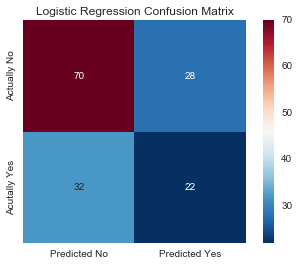

In [95]:
from sklearn.metrics import confusion_matrix
lrcm = (confusion_matrix(y_test, lr.predict(x_test)))

sns.heatmap(lrcm, annot=True,  square=True, fmt='', cmap='RdBu_r', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actually No', 'Acutally Yes']);
plt.title('Logistic Regression Confusion Matrix');
plt.savefig('lr_conf.png')

In [96]:
# Get odds ratio
odds = np.exp(lr.coef_)

In [97]:
c_names = list(c_dumm.columns.values)
print c_names

['AGE_DESC_19-24', 'AGE_DESC_25-34', 'AGE_DESC_35-44', 'AGE_DESC_45-54', 'AGE_DESC_55-64', 'AGE_DESC_65+', 'marital_status_code_A', 'marital_status_code_B', 'marital_status_code_U', 'income_desc_100-124K', 'income_desc_125-149K', 'income_desc_15-24K', 'income_desc_150-174K', 'income_desc_175-199K', 'income_desc_200-249K', 'income_desc_25-34K', 'income_desc_250K+', 'income_desc_35-49K', 'income_desc_50-74K', 'income_desc_75-99K', 'income_desc_Under 15K', 'homeowner_desc_Homeowner', 'homeowner_desc_Probable Owner', 'homeowner_desc_Probable Renter', 'homeowner_desc_Renter', 'homeowner_desc_Unknown', 'HH_COMP_DESC_1 Adult Kids', 'HH_COMP_DESC_2 Adults Kids', 'HH_COMP_DESC_2 Adults No Kids', 'HH_COMP_DESC_Single Female', 'HH_COMP_DESC_Single Male', 'HH_COMP_DESC_Unknown', 'KID_CATEGORY_DESC_1', 'KID_CATEGORY_DESC_2', 'KID_CATEGORY_DESC_3+', 'KID_CATEGORY_DESC_None/Unknown']


In [98]:
odds_summary = zip(c_names, odds[0])
odds_sum= pd.DataFrame(odds.T)
odds_sum['variable'] = c_names
a = odds_sum.sort_index(axis=1, ascending=False)
a.to_csv('odds_table.csv')

In [99]:
# Compute RMSE on training data
# p = np.array([ridge.predict(xi) for xi in x])
lr = LogisticRegression(random_state=101)
lr.fit(x_train, y_train)
p = lr.predict(x)
err = p-y
total_error = np.dot(err,err)
rmse_train = np.sqrt(total_error/len(p))

# Compute RMSE using 10-fold x-validation
kf = KFold(len(x), n_folds=10)
xval_err = 0
for train,test in kf:
    lr.fit(x[train],y[train])
    p = lr.predict(x[test])
    e = p-y[test]
    xval_err += np.dot(e,e)
rmse_10cv = np.sqrt(xval_err/len(x))

method_name = 'Logistic Regression'
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)

Method: Logistic Regression
RMSE on training: 0.0000
RMSE on 10-fold CV: 0.0000


In [100]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), x, y, scoring='accuracy', cv=10)
print 'cross_val_score = %s' %(np.mean(scores))

cross_val_score = 0.586758714969


In [101]:
# Predict response rate of full dataset
lrpreds_all = lr.predict(x)
print np.count_nonzero(lrpreds_all)
print np.count_nonzero(y)

178
311


In [102]:
lrpreds_test = lr.predict(x_test)
print np.count_nonzero(lrpreds_test)
print np.count_nonzero(y_test)

34
54


# Classification

### KNN

#### K=3, Distance

In [20]:
from sklearn import neighbors, tree, naive_bayes
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(x_train, y_train)
knnpreds_test = knnclf.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, knnpreds_test))
print "Test Accuracy: %s" % knnclf.score(x_test, y_test)  # Average accuracy test
print "Train Accuracy: %s" % knnclf.score(x_train, y_train)  # Average accuracy train
cv_scores = cross_validation.cross_val_score(knnclf, x, y, cv=5)
print("Overall Accuracy: %0.3f (+/- %0.3f)" % (cv_scores.mean(), cv_scores.std() * 2))

             precision    recall  f1-score   support

          0       0.64      0.62      0.63        98
          1       0.35      0.37      0.36        54

avg / total       0.54      0.53      0.54       152

Test Accuracy: 0.532894736842
Train Accuracy: 0.871710526316
Overall Accuracy: 0.529 (+/- 0.056)


#### K=3, Uniform

In [21]:
from sklearn import neighbors, tree, naive_bayes
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
knnclf.fit(x_train, y_train)
knnpreds_test = knnclf.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, knnpreds_test))
print "Test Accuracy: %s" % knnclf.score(x_test, y_test)  # Average accuracy test
print "Train Accuracy: %s" % knnclf.score(x_train, y_train)  # Average accuracy train
cv_scores = cross_validation.cross_val_score(knnclf, x, y, cv=5)
print("Overall Accuracy: %0.3f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

             precision    recall  f1-score   support

          0       0.68      0.60      0.64        98
          1       0.40      0.48      0.44        54

avg / total       0.58      0.56      0.57       152

Test Accuracy: 0.559210526316
Train Accuracy: 0.753289473684
Overall Accuracy: 0.539 (+/- 0.04)


#### K=5,  Distance

In [22]:
n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(x_train, y_train)
knnpreds_test = knnclf.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, knnpreds_test))
print "Test Accuracy: %s" % knnclf.score(x_test, y_test)  # Average accuracy test
print "Train Accuracy: %s" % knnclf.score(x_train, y_train)  # Average accuracy train
cv_scores = cross_validation.cross_val_score(knnclf, x, y, cv=5)
print("Overall Accuracy: %0.3f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

             precision    recall  f1-score   support

          0       0.61      0.59      0.60        98
          1       0.30      0.31      0.31        54

avg / total       0.50      0.49      0.50       152

Test Accuracy: 0.493421052632
Train Accuracy: 0.871710526316
Overall Accuracy: 0.551 (+/- 0.06)


#### K=5, Uniform weight

In [23]:
from sklearn import neighbors, tree, naive_bayes
n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
knnclf.fit(x_train, y_train)
knnpreds_test = knnclf.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, knnpreds_test))
print "Test Accuracy: %s" % knnclf.score(x_test, y_test)  # Average accuracy test
print "Train Accuracy: %s" % knnclf.score(x_train, y_train)  # Average accuracy train
cv_scores = cross_validation.cross_val_score(knnclf, x, y, cv=5)
print("Overall Accuracy: %0.3f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

             precision    recall  f1-score   support

          0       0.60      0.56      0.58        98
          1       0.28      0.31      0.30        54

avg / total       0.49      0.47      0.48       152

Test Accuracy: 0.473684210526
Train Accuracy: 0.708881578947
Overall Accuracy: 0.553 (+/- 0.04)


#### K=10  Distance

In [24]:
from sklearn import neighbors, tree, naive_bayes
n_neighbors = 10
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(x_train, y_train)
knnpreds_test = knnclf.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, knnpreds_test))
print "Test Accuracy: %s" % knnclf.score(x_test, y_test)  # Average accuracy test
print "Train Accuracy: %s" % knnclf.score(x_train, y_train)  # Average accuracy train
cv_scores = cross_validation.cross_val_score(knnclf, x, y, cv=5)
print("Overall Accuracy: %0.3f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

             precision    recall  f1-score   support

          0       0.64      0.70      0.67        98
          1       0.34      0.28      0.31        54

avg / total       0.53      0.55      0.54       152

Test Accuracy: 0.552631578947
Train Accuracy: 0.871710526316
Overall Accuracy: 0.570 (+/- 0.05)


#### K=10, uniform

In [25]:
from sklearn import neighbors, tree, naive_bayes
n_neighbors = 10
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
knnclf.fit(x_train, y_train)
knnpreds_test = knnclf.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, knnpreds_test))
print "Test Accuracy: %s" % knnclf.score(x_test, y_test)  # Average accuracy test
print "Train Accuracy: %s" % knnclf.score(x_train, y_train)  # Average accuracy train
cv_scores = cross_validation.cross_val_score(knnclf, x, y, cv=5)
print("Overall Accuracy: %0.3f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

             precision    recall  f1-score   support

          0       0.67      0.82      0.73        98
          1       0.44      0.26      0.33        54

avg / total       0.59      0.62      0.59       152

Test Accuracy: 0.618421052632
Train Accuracy: 0.657894736842
Overall Accuracy: 0.582 (+/- 0.04)


#### K=20, distance

In [26]:
n_neighbors = 20
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(x_train, y_train)
knnpreds_test = knnclf.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, knnpreds_test))
print "Test Accuracy: %s" % knnclf.score(x_test, y_test)  # Average accuracy test
print "Train Accuracy: %s" % knnclf.score(x_train, y_train)  # Average accuracy train
cv_scores = cross_validation.cross_val_score(knnclf, x, y, cv=5)
print("Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

             precision    recall  f1-score   support

          0       0.63      0.67      0.65        98
          1       0.33      0.30      0.31        54

avg / total       0.53      0.54      0.53       152

Test Accuracy: 0.539473684211
Train Accuracy: 0.871710526316
Overall Accuracy: 0.57 (+/- 0.04)


#### K=20, uniform

In [29]:
from sklearn import neighbors, tree, naive_bayes
n_neighbors = 20
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
knnclf.fit(x_train, y_train)
knnpreds_test = knnclf.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, knnpreds_test))
print "Test Accuracy: %s" % knnclf.score(x_test, y_test)  # Average accuracy test
print "Train Accuracy: %s" % knnclf.score(x_train, y_train)  # Average accuracy train
cv_scores = cross_validation.cross_val_score(knnclf, x, y, cv=5)
print("Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

             precision    recall  f1-score   support

          0       0.65      0.79      0.71        98
          1       0.38      0.24      0.30        54

avg / total       0.56      0.59      0.56       152

Test Accuracy: 0.592105263158
Train Accuracy: 0.641447368421
Overall Accuracy: 0.58 (+/- 0.04)


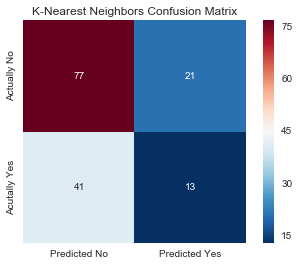

In [30]:
from sklearn.metrics import confusion_matrix
knncm = (confusion_matrix(y_test, knnpreds_test))

sns.heatmap(knncm, annot=True,  square=True, fmt='', cmap='RdBu_r', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actually No', 'Acutally Yes']);
plt.title('K-Nearest Neighbors Confusion Matrix');
plt.savefig('knn_conf.png')

## Decision Tree

#### Gini

In [32]:
treeclf = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=5, max_features=6, max_depth=2)
treeclf = treeclf.fit(x_train, y_train)
treepreds_test = treeclf.predict(x_test)
print(classification_report(y_test, treepreds_test))
print "Training accuracy: %s" % treeclf.score(x_train, y_train)
print "Testing accuracy: %s" % treeclf.score(x_test, y_test)
cv_scores = cross_validation.cross_val_score(treeclf, x, y, cv=5)
print("Overall Accuracy: %0.3f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

             precision    recall  f1-score   support

          0       0.64      1.00      0.78        98
          1       0.00      0.00      0.00        54

avg / total       0.42      0.64      0.51       152

Training accuracy: 0.577302631579
Testing accuracy: 0.644736842105
Overall Accuracy: 0.595 (+/- 0.01)


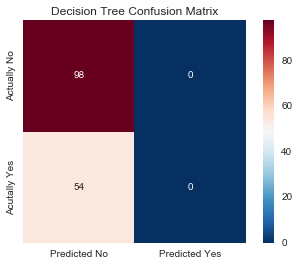

In [33]:
from sklearn.metrics import confusion_matrix
treecm = (confusion_matrix(y_test, treepreds_test))

sns.heatmap(treecm, annot=True,  square=True, fmt='', cmap='RdBu_r', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actually No', 'Acutally Yes']);
plt.title('Decision Tree Confusion Matrix');
plt.savefig('tree_conf.png')

### Naive Bayes

In [103]:
nbclf = naive_bayes.BernoulliNB(binarize=None, alpha=1)
nbclf = nbclf.fit(x_train, y_train)
nbpreds_test = nbclf.predict(x_test)
print nbclf.score(x_train, y_train)
print nbclf.score(x_test, y_test)

0.625
0.572368421053


In [104]:
from sklearn import cross_validation
cv_scores = cross_validation.cross_val_score(treeclf, x, y, cv=5)
cv_scores

array([ 0.6 ,  0.59,  0.59,  0.59,  0.6 ])

In [105]:
print("Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Overall Accuracy: 0.59 (+/- 0.01)


In [106]:
print(classification_report(y_test, nbpreds_test))

             precision    recall  f1-score   support

          0       0.70      0.58      0.64        98
          1       0.42      0.56      0.48        54

avg / total       0.60      0.57      0.58       152



In [107]:
from sklearn.naive_bayes import BernoulliNB
# test the model for alpha = 0.1, 0.2, ..., 1.0
parameters = [{'alpha':np.linspace(0.1,1,10)}, {'fit_prior':('True','False')}]

from sklearn.grid_search import GridSearchCV
clf = GridSearchCV(BernoulliNB(), parameters, cv=10, scoring='accuracy')
clf.fit(x_train,y_train) # running the grid search

GridSearchCV(cv=10, error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])}, {'fit_prior': ('True', 'False')}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)

In [108]:
print clf.best_estimator_
print clf.best_score_
print clf.best_params_

BernoulliNB(alpha=0.40000000000000002, binarize=0.0, class_prior=None,
      fit_prior=True)
0.578947368421
{'alpha': 0.40000000000000002}


#### NB with optimal settings

In [109]:
nbclf = naive_bayes.BernoulliNB(binarize=None, alpha=0.4, fit_prior=True)
nbclf = nbclf.fit(x_train, y_train)
nbpreds_test = nbclf.predict(x_test)
print nbclf.score(x_train, y_train)
print nbclf.score(x_test, y_test)

0.625
0.565789473684


In [110]:
cv_scores = cross_validation.cross_val_score(nbclf, x, y, cv=5)
cv_scores
print(classification_report(y_test, nbpreds_test))


             precision    recall  f1-score   support

          0       0.70      0.57      0.63        98
          1       0.42      0.56      0.48        54

avg / total       0.60      0.57      0.57       152



In [111]:
from sklearn.metrics import confusion_matrix
nbcm = (confusion_matrix(y_test, nbpreds_test))
print nbcm

[[56 42]
 [24 30]]


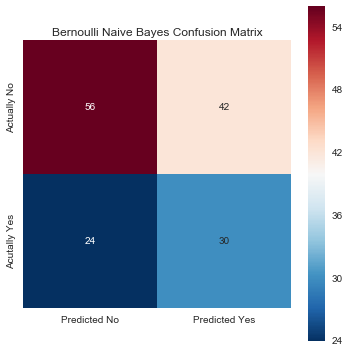

In [112]:
plt.figure(figsize=(6,6))
sns.heatmap(nbcm, annot=True,  square=True, fmt='', cmap='RdBu_r', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actually No', 'Acutally Yes']);
plt.title('Bernoulli Naive Bayes Confusion Matrix');
plt.savefig('nb_conf.png')

In [113]:
# Predict response rate of full dataset
nbpreds_all = nbclf.predict(x)
print np.count_nonzero(nbpreds_all)
print np.count_nonzero(y)

353
311


In [114]:
nbpreds_train = nbclf.predict(x_train)
print np.count_nonzero(nbpreds_train)
print np.count_nonzero(y_train)

281
257
